<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Probabilistic-Bayesian-Neural-Network" data-toc-modified-id="Probabilistic-Bayesian-Neural-Network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Probabilistic Bayesian Neural Network</a></span><ul class="toc-item"><li><span><a href="#Models-using-only-the-ensemble-mean" data-toc-modified-id="Models-using-only-the-ensemble-mean-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Models using only the ensemble mean</a></span></li><li><span><a href="#Model-with-2-dim-Input-(mean,-std)" data-toc-modified-id="Model-with-2-dim-Input-(mean,-std)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model with 2-dim Input (mean, std)</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Hyperparameter tuning</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Forecast" data-toc-modified-id="Forecast-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Forecast</a></span></li></ul></li><li><span><a href="#First-PBNN-Approach-(Keras-Tutorial)" data-toc-modified-id="First-PBNN-Approach-(Keras-Tutorial)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>First PBNN Approach (Keras Tutorial)</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
from datetime import date, datetime, timedelta
from dateutil.tz import tzutc
from os.path import exists
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
today = datetime.today().strftime("%Y%m%d")
today

'20230215'

In [3]:
path_fc_icon_eu_eps = (
    "../kit-weather-ensemble-point-forecast-karlsruhe/icon-eu-eps_"
    + today
    + "00_wind_mean_10m_Karlsruhe.txt"
)
fc_icon_eu_eps = pd.read_csv(path_fc_icon_eu_eps, sep="|", header=3, index_col=1).iloc[:,1:41]
fc_icon_eu_eps

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
fcst_hour,,,,,,,,,,,,,,,,,,,,,
0,6.24,3.33,3.52,4.74,3.42,3.31,4.96,3.39,3.67,2.21,...,5.77,6.35,2.36,6.59,3.92,5.42,3.15,7.37,5.30,6.33
1,6.14,3.06,3.42,4.49,3.99,2.26,4.16,3.42,3.88,1.84,...,4.59,6.04,2.57,5.45,4.92,5.12,3.81,6.26,5.52,5.01
2,6.13,2.58,2.84,3.60,4.82,2.01,3.33,3.74,4.05,2.03,...,2.88,5.57,3.02,4.23,5.19,4.88,4.05,4.95,5.02,3.40
3,5.79,2.52,2.80,2.90,5.52,2.13,2.78,4.36,3.93,1.98,...,1.86,5.13,3.14,3.57,4.99,4.54,3.95,4.17,4.41,1.91
4,5.82,2.66,2.75,1.98,5.22,1.61,2.30,4.32,3.35,2.29,...,1.24,4.72,3.61,3.37,4.50,4.04,3.42,3.30,3.96,1.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,15.29,8.54,12.26,15.61,9.03,9.65,28.22,6.33,15.22,6.36,...,8.08,17.79,14.22,9.96,11.14,18.99,8.42,5.68,19.84,12.28
102,17.53,18.11,13.54,11.02,10.68,9.29,25.01,11.10,9.94,10.96,...,7.28,16.51,16.26,9.00,13.23,17.84,11.18,10.09,21.34,7.22
108,18.08,17.52,18.05,16.76,16.05,8.38,20.87,20.14,12.76,17.27,...,10.58,19.45,19.50,15.04,25.11,12.42,18.47,8.38,21.28,7.25


<AxesSubplot:xlabel=' fcst_hour '>

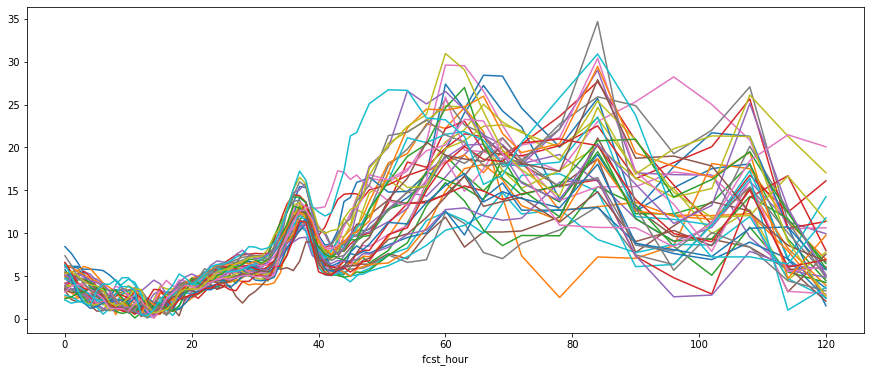

In [4]:
fc_icon_eu_eps.plot(figsize=(15,6), legend=False)

In [5]:
target_horizons = [36, 48, 60, 72, 84]

In [6]:
fc_mean = fc_icon_eu_eps.mean(axis=1)
fc_std = fc_icon_eu_eps.std(axis=1)
fc_raw = pd.DataFrame({"mean": fc_mean, "std": fc_std})
fc_raw.reset_index(inplace=True)
fc_raw.rename(columns={' fcst_hour ': 'fcst_hour'}, inplace=True)
fc_raw = fc_raw.set_index("fcst_hour")
fc_raw.loc[target_horizons,:]

,mean,std
fcst_hour,,
36,11.50750,2.039267
48,11.27125,4.442394
60,19.41250,5.126966
72,16.72875,3.878202
84,20.32975,6.322501


In [7]:
datetime.today().weekday()

2

In [8]:
# get dates of all wednesdays since data is available in repository
d = date(2021, 9, 8)  # 1st wednesday data set
wednesdays = []
while d < date.today():
    wednesdays.append(d.strftime("%Y%m%d"))
    d += timedelta(days=7)

In [9]:
# read historic forecasts and calculate mean and std of ensemble
fc_historic = []

for date in wednesdays:
    path_fc_historic = (
        "../kit-weather-ensemble-point-forecast-karlsruhe/icon-eu-eps_"
        + date
        + "00_wind_mean_10m_Karlsruhe.txt"
    )
    
    if exists(path_fc_historic):
        fc_ = pd.read_csv(path_fc_historic, sep="|", header=3, index_col=1).iloc[
            :, 1:41
        ]
        fc_ = fc_.loc[target_horizons, :]

        fc_mean = fc_.mean(axis=1)
        fc_std = fc_.std(axis=1)
        fc_ = pd.DataFrame(
            {
                "datetime": [
                    datetime.strptime(date, "%Y%m%d").replace(tzinfo=tzutc()) + timedelta(hours=h)
                    for h in target_horizons
                ],
                "mean": fc_mean,
                "std": fc_std,
            }
        )

        fc_historic.append(fc_)

fc_historic = pd.concat(fc_historic).reset_index()
fc_historic.rename(columns={' fcst_hour ': 'fcst_hour'}, inplace=True)

In [10]:
station_id = "04177"
yesterday = (datetime.today() - pd.DateOffset(days=1)).strftime("%Y%m%d")
start_historic = (datetime.today() - pd.DateOffset(days=550)).strftime("%Y%m%d")
file_historic = "produkt_ff_stunde_" + start_historic + "_" + yesterday + "_" + station_id + ".txt"
path_historic = "../project/data/weather/stundenwerte_FF_" + station_id + "_akt/" + file_historic
path_historic

'../project/data/weather/stundenwerte_FF_04177_akt/produkt_ff_stunde_20210814_20230214_04177.txt'

In [11]:
#path_historic = "../project/data/weather/stundenwerte_FF_04177_akt/produkt_ff_stunde_20210723_20230123_04177.txt"

In [12]:
historic_data = pd.read_csv(path_historic, sep=";").loc[:, ["MESS_DATUM", "   F"]]
historic_data.columns = ["datetime", "mean_wind_speed"]
historic_data.loc[:, "datetime"] = historic_data.datetime.apply(
    lambda x: datetime.strptime(str(x), "%Y%m%d%H").replace(tzinfo=tzutc())
)
historic_data

,datetime,mean_wind_speed
0,2021-08-14 00:00:00+00:00,0.9
1,2021-08-14 01:00:00+00:00,0.6
2,2021-08-14 02:00:00+00:00,0.6
3,2021-08-14 03:00:00+00:00,0.5
4,2021-08-14 04:00:00+00:00,0.5
...,...,...
13194,2023-02-14 19:00:00+00:00,0.7
13195,2023-02-14 20:00:00+00:00,0.7
13196,2023-02-14 21:00:00+00:00,0.5
13197,2023-02-14 22:00:00+00:00,1.0


In [13]:
historic_data.mean_wind_speed.mean()

3.2243503295704223

In [14]:
historic_data.mean_wind_speed.std()**2

5.058149250195186

In [15]:
data = historic_data.merge(fc_historic, how="inner", on="datetime").set_index("datetime")
X = data[["mean", "std"]]
y = data["mean_wind_speed"]
data

,mean_wind_speed,fcst_hour,mean,std
datetime,,,,
2021-09-09 12:00:00+00:00,6.8,36,12.56225,1.863514
2021-09-10 00:00:00+00:00,1.9,48,4.29000,1.274688
2021-09-10 12:00:00+00:00,2.5,60,8.43150,3.378290
2021-09-11 00:00:00+00:00,2.7,72,4.81825,1.390550
2021-09-11 12:00:00+00:00,3.4,84,10.22800,3.628088
...,...,...,...,...
2023-02-09 12:00:00+00:00,2.2,36,5.48300,2.131705
2023-02-10 00:00:00+00:00,1.6,48,5.23250,1.210894
2023-02-10 12:00:00+00:00,3.5,60,7.86075,3.099715


# Probabilistic Bayesian Neural Network

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import GPyOpt
from sklearn.model_selection import GridSearchCV
#import CRPS.CRPS as pscore
#import properscoring as ps
tfd = tfp.distributions

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data[["mean", "std"]], data["mean_wind_speed"], train_size=0.85, shuffle=False
)

mean_max = X_train["mean"].max()
std_max = X_train["std"].max()
y_max = Y_train.max()

x_mean_train = np.array(X_train["mean"] / mean_max).reshape(-1, 1)
x_mean_test = np.array(X_test["mean"] / mean_max).reshape(-1, 1)
x_std_train = np.array(X_train["std"] / std_max).reshape(-1, 1)
x_std_test = np.array(X_test["std"] / std_max).reshape(-1, 1)
y_train = np.array(Y_train / y_max).reshape(-1, 1)
y_test = np.array(Y_test / y_max).reshape(-1, 1)

x_train = pd.DataFrame({"mean": X_train["mean"] / mean_max, "std": X_train["std"] / std_max})
x_test = pd.DataFrame({"mean": X_test["mean"] / mean_max, "std": X_test["std"] / std_max})

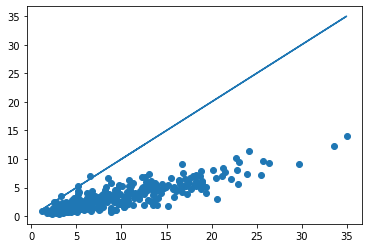

In [18]:
plt.scatter(X_train["mean"], Y_train)
plt.plot(X_train["mean"], X_train["mean"])
plt.show()

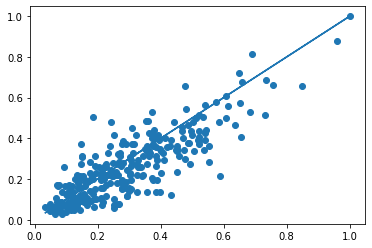

In [19]:
plt.scatter(x_train["mean"], y_train)
plt.plot(x_train["mean"], x_train["mean"])
plt.show()

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#    data[["mean", "std"]], data["mean_wind_speed"], train_size=0.85, shuffle=False
# )
# x_mean_train = np.array(x_train["mean"]).reshape(-1,1)
# x_std_train = np.array(x_train["std"]).reshape(-1,1)
# y_train = np.array(y_train).reshape(-1,1)
# x_mean_test = np.array(x_test["mean"]).reshape(-1,1)
# x_std_test = np.array(x_test["std"]).reshape(-1,1)
# y_test = np.array(y_test).reshape(-1,1)

## Models using only the ensemble mean

In [ ]:
# Build model.
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(1),
        tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
    ]
)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x_train, y_train, epochs=1000, verbose=False)
print(model.summary())

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_test)
print(yhat)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6,4])
plt.plot(x_test, y_test, 'b.', label='observed');
plt.plot(x_test, yhat.mean(),'r', label='mean', linewidth=2);

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

In [ ]:
# Build model.
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])
            )
        ),
    ]
)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x_train, y_train, epochs=1000, verbose=False)

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_test)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
plt.figure(figsize=[6, 4])  # inches
plt.plot(x_train, y_train, 'c.', label='train');
plt.plot(x_test, y_test, 'b.', label='test');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_test, m, 'r', linewidth=2, label='mean');
plt.plot(x_test, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_test, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

In [ ]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(2 * n, dtype=dtype),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Independent(
                    tfd.Normal(
                        loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])
                    ),
                    reinterpreted_batch_ndims=1,
                )
            ),
        ]
    )

In [ ]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(n, dtype=dtype),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Independent(
                    tfd.Normal(loc=t, scale=1), reinterpreted_batch_ndims=1
                )
            ),
        ]
    )

In [ ]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x_train, y_train, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_test)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
plt.figure(figsize=[6, 4])
plt.clf()
plt.plot(x_train, y_train, "c.", label="train")
plt.plot(x_test, y_test, "b.", label="test")

yhats = [model(x_test) for _ in range(100)]
avgm = np.zeros_like(x_test[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 25:
        plt.plot(
            x_test, m, "r", label="ensemble means" if i == 0 else None, linewidth=0.5
        )
    avgm += m
plt.plot(x_test, avgm / len(yhats), "r", label="overall mean", linewidth=2)

ax = plt.gca()
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0.0, bbox_to_anchor=(1.05, 0.5))
plt.show()

In [ ]:
# Build model.
model = tf.keras.Sequential(
    [
        tfp.layers.DenseVariational(
            1 + 1, posterior_mean_field, prior_trainable, kl_weight=1 / x.shape[0]
        ),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])
            )
        ),
    ]
)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x_train, y_train, epochs=1000, verbose=False)

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_test)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
plt.figure(figsize=[6, 4])
plt.plot(x_train, y_train, "c.", label="train")
plt.plot(x_test, y_test, "b.", label="test")

yhats = [model(x_test) for _ in range(100)]
avgm = np.zeros_like(x_test[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(
            x_test, m, "r", label="ensemble means" if i == 0 else None, linewidth=1.0
        )
        plt.plot(
            x_test,
            m + 2 * s,
            "g",
            linewidth=0.5,
            label="ensemble means + 2 ensemble stdev" if i == 0 else None,
        )
        plt.plot(
            x_test,
            m - 2 * s,
            "g",
            linewidth=0.5,
            label="ensemble means - 2 ensemble stdev" if i == 0 else None,
        )
    avgm += m
plt.plot(x_test, avgm / len(yhats), "r", label="overall mean", linewidth=2)

ax = plt.gca()
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0.0, bbox_to_anchor=(1.05, 0.5))
plt.show()

## Model with 2-dim Input (mean, std)

In [20]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
FEATURE_NAMES = ["mean", "std"]
train_size = X_train.shape[0]
# learning_rate = 0.001
num_epochs = 1000
batch_size = 1
lower_bound = 0
upper_bound = 2

In [21]:
# put data into tensor with respective batch size
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train), y_train)).batch(
    batch_size=batch_size
)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test), y_test)).batch(
    batch_size=batch_size
)

In [22]:
std_emp = pd.Series(y_train.reshape(-1)).std()

In [23]:
def crps_score(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)

    # Create the cumulative density function for each prediction
    #cdf = tfd.TruncatedNormal(loc=y_pred, scale=1.0, low=lower_bound, high=upper_bound).cdf
    cdf = tfd.Gamma(concentration=(y_pred/std_emp)**2, rate=y_pred / std_emp**2).cdf

    # Calculate the CRPS score for each prediction
    crps = tf.reduce_mean(tf.square(cdf(y_true) - 0.5))

    return crps

In [24]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(2*n, dtype=dtype),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Independent(
                    tfd.Normal(
                        loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])
                    ),
                    reinterpreted_batch_ndims=1,
                )
            ),
        ]
    )

In [25]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(n, dtype=dtype),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Independent(
                    tfd.Normal(loc=t, scale=0.1), reinterpreted_batch_ndims=1
                )
            ),
        ]
    )

In [26]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.models.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfd.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    # lambda parameter t is not used in the Multivariate Distribution
    return prior_model


# Define variational posterior weight distribution -- multivariate Gaussian
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    post_model = tf.keras.models.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return post_model

In [27]:
def create_pbnn_model(num_units=64, initial_learning_rate=0.01, decrease_lr_after=20):
    inputs = {}
    #normalization = {}
    dense_layers = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
        #normalization[feature_name] = layers.BatchNormalization(name=feature_name + "_normalization")(inputs[feature_name])
        dense_layers[feature_name] = tfp.layers.DenseVariational(
            num_units,
            posterior,
            prior,
            kl_weight=1 / x_train.shape[0],
            activation="elu",
            name=feature_name + "_variational",
        )(inputs[feature_name])

    features = keras.layers.concatenate(list(dense_layers.values()), name="concatenate")
    distribution_params = layers.Dense(
        units=2, activation="elu", name="distribution_params"
    )(features)
    outputs = tfp.layers.DistributionLambda(
        # lambda t: tfp.distributions.TruncatedNormal(
        #    loc=1e-3 + tf.math.softplus(0.05 * t[:, :1]),
        #    scale=1e-3 + tf.math.softplus(0.05 * t[:, 1:]),
        #    low=lower_bound,
        #    high=upper_bound,
        # ),
        lambda t: tfp.distributions.Gamma(
            concentration=1e-3 + tf.math.softplus(0.5 * t[:, 0:1]),
            rate=1e-3 + tf.math.softplus(0.05 * t[:, 1:2]),
        ),
        name="output",
    )(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss=negloglik)

    return model

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


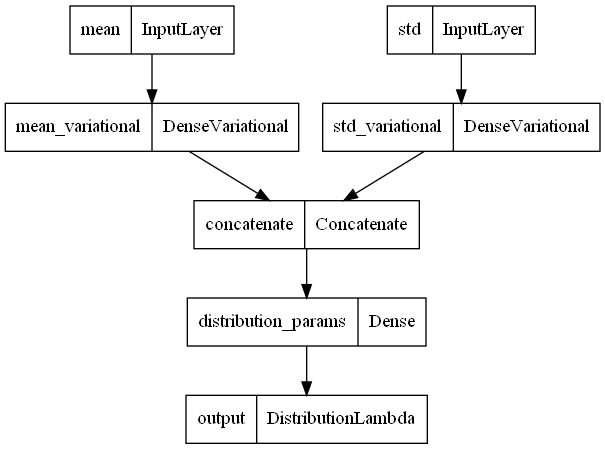

In [28]:
model = create_pbnn_model()
tf.keras.utils.plot_model(model)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mean (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 std (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 mean_variational (DenseVariati  (None, 64)          8384        ['mean[0][0]']                   
 onal)                                                                                            
                                                                                                  
 std_variational (DenseVariatio  (None, 64)          8384        ['std[0][0]']                

In [30]:
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [31]:
callback_lr_scheduler = callbacks.LearningRateScheduler(scheduler)
callback_early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [32]:
model.fit(
    train_dataset,
    epochs=num_epochs,
    callbacks=[callback_lr_scheduler, callback_early_stopping],
    verbose=True,
    validation_data=test_dataset,
)

Epoch 1/1000
297/297 [==============================] - 3s 5ms/step - loss: 0.2798 - val_loss: 0.4636 - lr: 0.0100
Epoch 2/1000
297/297 [==============================] - 1s 3ms/step - loss: 0.2111 - val_loss: 0.6937 - lr: 0.0100
Epoch 3/1000
297/297 [==============================] - 1s 3ms/step - loss: 0.2917 - val_loss: 0.7039 - lr: 0.0100
Epoch 4/1000
297/297 [==============================] - 1s 3ms/step - loss: 0.2961 - val_loss: 0.6014 - lr: 0.0100
Epoch 5/1000
297/297 [==============================] - 1s 3ms/step - loss: 0.2007 - val_loss: 0.6280 - lr: 0.0100
Epoch 6/1000
297/297 [==============================] - 1s 2ms/step - loss: 0.1891 - val_loss: 0.5111 - lr: 0.0100
Epoch 7/1000
297/297 [==============================] - 1s 3ms/step - loss: 0.1965 - val_loss: 0.5314 - lr: 0.0100
Epoch 8/1000
297/297 [==============================] - 1s 3ms/step - loss: 0.4648 - val_loss: 1.0690 - lr: 0.0100
Epoch 9/1000
297/297 [==============================] - 1s 3ms/step - loss: 0.51

### Hyperparameter tuning

In [ ]:
# Define the hyperparameters to tune
num_units = [1, 16, 32, 64, 128]
batch_sizes = [1, 2, 4, 8, 16, 32]
learning_rates = [0.001, 0.005, 0.01]
decrease_after = [10, 20, 30]

# Define the search space for the hyperparameters
search_space = {
    "num_units": num_units,
    "batch_size": batch_sizes,
    "learning_rate": learning_rates,
    "decrease_after": decrease_after,
}

In [ ]:
# Define the evaluation function for the hyperparameters
def evaluate_hyperparams(num_units, batch_size, learning_rate, decrease_after):
    # Unpack the hyperparameters
    # num_units = int(hyperparams[:, 0][0])
    # batch_size = int(hyperparams[:, 1][0])
    # learning_rate = hyperparams[:, 2][0]
    # decrease_after = int(hyperparams[:, 3][0])

    # Compile the model with the current hyperparameters
    model = create_pbnn_model(
        num_units=num_units,
        initial_learning_rate=learning_rate,
        decrease_lr_after=decrease_after,
    )

    scheduler = (
        lambda epoch, lr: lr if epoch < decrease_after else lr * tf.math.exp(-0.1)
    )
    callback_lr_scheduler = callbacks.LearningRateScheduler(scheduler)
    callback_early_stopping = callbacks.EarlyStopping(
        monitor="loss", patience=20, restore_best_weights=True
    )

    # put data into tensor with respective batch size
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train), y_train)).batch(
        batch_size=batch_size
    )
    test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test), y_test)).batch(
        batch_size=batch_size
    )

    # Train the model with the current hyperparameters
    history = model.fit(
        train_dataset,
        epochs=200,
        batch_size=batch_size,
        callbacks=[callback_lr_scheduler, callback_early_stopping],
        verbose=0,
    )

    # Evaluate the model on the validation set
    loss = 0
    for x, y in test_dataset:
        loss += crps_score(y.astype("float32"), model(x, training=False)).numpy().mean()
    loss = loss / (len(y_test) / batch_size)

    return loss

In [ ]:
from itertools import product
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
keys, values = zip(*search_space.items())
grid = [dict(zip(keys, p)) for p in product(*values)]

for i, hp in enumerate(grid[0:150]):
    print(i)
    print(hp)
    grid[i]["loss"] = evaluate_hyperparams(**hp)
    print(grid[i]["loss"])

In [ ]:
import csv

In [ ]:
losses_150_270

In [ ]:
for i in np.arange(150,270,1):
    grid[i]["loss"] = losses_150_270[i-150]

In [ ]:
grid

In [ ]:
myFile = open('otherFiles/grid_search_results.csv', 'w')
writer = csv.writer(myFile)
writer.writerow(['num_units', 'batch_size', 'learning_rate', 'decrease_after', 'loss'])
for d in grid:
    writer.writerow(d.values())
myFile.close()

In [ ]:
grid_search_results = pd.read_csv('otherFiles/grid_search_results.csv')
grid_search_results

In [ ]:
grid_search_results.sort_values("loss")

In [ ]:
from tensorcross.model_selection import GridSearchCV

grid_search = GridSearchCV(
    model_fn=create_pbnn_model,
    param_grid=search_space,
    n_folds=3,
    verbose=1,
)

grid_search.fit(
    dataset=train_dataset, epochs=100, verbose=0
)

grid_search.summary()

In [ ]:
grid_search.results_["best_params"]

In [ ]:
num_units = grid_search.results_["best_params"]["num_units"] # 64
learning_rate = grid_search.results_["best_params"]["initial_learning_rate"] # 0.01

# Compile the model with the current hyperparameters
model = create_pbnn_model(num_units=num_units, initial_learning_rate=learning_rate)

callback_lr_scheduler = callbacks.LearningRateScheduler(scheduler)
callback_early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with the current hyperparameters
history = model.fit(
    train_dataset,
    epochs=500,
    callbacks=[callback_lr_scheduler, callback_early_stopping],
    verbose=2,
    validation_data=test_dataset
)

In [ ]:
# Perform the Bayesian optimization
bo = GPyOpt.methods.BayesianOptimization(
    f=evaluate_hyperparams,
    domain=search_space,
    normalize_Y=False,
)

# Run the optimization
bo.run_optimization(max_iter=200, verbosity=True)

In [ ]:
# Get the best hyperparameters found by the optimization
best_hyperparams = bo.x_opt
for i in range(4):
    print(search_space[i]["name"], ":\t", best_hyperparams[i])

In [ ]:
num_units = int(best_hyperparams[0]) # 32
batch_size = int(best_hyperparams[1]) #32
learning_rate = best_hyperparams[2] # 0.01
decrease_after = int(best_hyperparams[3]) # 20

# Compile the model with the current hyperparameters
model = create_pbnn_model(num_units=num_units)
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=crps_score)

# put data into tensor with respective batch size
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train), y_train)).batch(
    batch_size=batch_size
)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test), y_test)).batch(
    batch_size=batch_size
)

scheduler = lambda epoch, lr: lr if epoch < decrease_after else lr * tf.math.exp(-0.1)
callback_lr_scheduler = callbacks.LearningRateScheduler(scheduler)
callback_early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with the current hyperparameters
history = model.fit(
    train_dataset,
    epochs=500,
    callbacks=[callback_lr_scheduler, callback_early_stopping],
    verbose=2,
    validation_data=test_dataset
)

### Plots

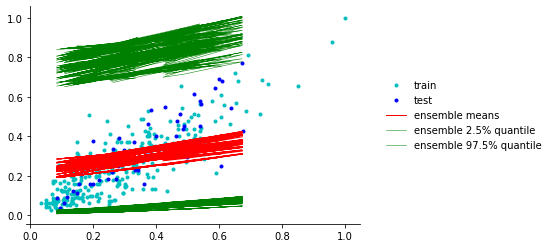

In [33]:
plt.figure(figsize=[6, 4])
plt.plot(x_mean_train, y_train, "c.", label="train")
plt.plot(x_mean_test, y_test, "b.", label="test")

yhats = [model([x_mean_test, x_std_test]) for _ in range(100)]
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    ql = np.squeeze(yhat.quantile(0.025))
    qu = np.squeeze(yhat.quantile(0.975))
    if i < 20:
        plt.plot(
            x_mean_test,
            m,
            "r",
            label="ensemble means" if i == 0 else None,
            linewidth=1.0
        )
        plt.plot(
            x_mean_test,
            ql,
            "g",
            linewidth=0.5,
            label="ensemble 2.5% quantile" if i == 0 else None,
        )
        plt.plot(
            x_mean_test,
            qu,
            "g",
            linewidth=0.5,
            label="ensemble 97.5% quantile" if i == 0 else None,
        )

ax = plt.gca()
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0.0, bbox_to_anchor=(1.05, 0.5))
plt.show()

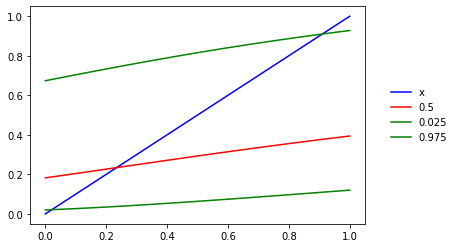

In [34]:
x = np.linspace(0, 1, 40)
yhat_dist = model([x, np.ones(len(x))])

plt.figure(figsize=[6, 4])
plt.plot(x, x, "b", label="x")
plt.plot(x, yhat_dist.quantile(0.5)[:, 0], "r", label="0.5")
plt.plot(x, yhat_dist.quantile(0.025)[:, 0], "g", label=r"0.025")
plt.plot(x, yhat_dist.quantile(0.975)[:, 0], "g", label=r"0.975")
plt.legend(loc="center left", fancybox=True, framealpha=0.0, bbox_to_anchor=(1.05, 0.5))
plt.show()

### Forecast

In [35]:
ensemble_forecast = fc_raw.loc[target_horizons, :].reset_index()
x_mean_fc = np.array(ensemble_forecast["mean"] / mean_max).reshape(-1,1)
x_std_fc = np.array(ensemble_forecast["std"] / std_max).reshape(-1,1)

In [36]:
yhats = [model([x_mean_fc, x_std_fc]) for _ in range(100)]
q0025 = np.array([yhat.quantile(0.025)[:,0] for yhat in yhats])
q025 = np.array([yhat.quantile(0.25)[:,0] for yhat in yhats])
q05 = np.array([yhat.quantile(0.5)[:,0] for yhat in yhats])
q075 = np.array([yhat.quantile(0.75)[:,0] for yhat in yhats])
q0975 = np.array([yhat.quantile(0.975)[:,0] for yhat in yhats])

In [37]:
df_sub = pd.DataFrame({
    "forecast_date": datetime.today().strftime("%Y-%m-%d"),
    "target": "wind",
    "horizon": [str(i) + " hour" for i in target_horizons],
    "q0.025": q0025.mean(axis=0) * y_max,
    "q0.25": q025.mean(axis=0) * y_max,
    "q0.5": q05.mean(axis=0) * y_max,
    "q0.75": q075.mean(axis=0) * y_max,
    "q0.975": q0975.mean(axis=0) * y_max})
df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-02-15,wind,36 hour,0.511569,1.994004,3.469808,5.557165,11.482829
1,2023-02-15,wind,48 hour,0.522858,1.993238,3.442955,5.484480,11.256970
2,2023-02-15,wind,60 hour,0.861450,2.635914,4.220932,6.353220,12.128258
3,2023-02-15,wind,72 hour,0.734555,2.419819,3.975942,6.102118,11.946858
4,2023-02-15,wind,84 hour,0.912010,2.708871,4.292580,6.409708,12.108692


In [38]:
fc_raw.loc[target_horizons, :]

,mean,std
fcst_hour,,
36,11.50750,2.039267
48,11.27125,4.442394
60,19.41250,5.126966
72,16.72875,3.878202
84,20.32975,6.322501


In [39]:
df_sub.to_csv("otherFiles/"+today+"_wind_pbnn.csv", index=False)

## First PBNN Approach (Keras Tutorial)

In [ ]:
def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [ ]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs

In [ ]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [ ]:
def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
#prob_bnn_model = create_probablistic_bnn_model(train_size)
#tf.keras.utils.plot_model(prob_bnn_model, to_file="pbnn_model1.png")

In [ ]:
inputs = {}
dense_layers = {}
for feature_name in FEATURE_NAMES:
    inputs[feature_name] = layers.Input(
        name=feature_name, shape=(1,), dtype=tf.float32
    )
    normalization = layers.BatchNormalization()(inputs[feature_name])
    dense_layers[feature_name] = tfp.layers.DenseVariational(
        units=64,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1 / train_size,
        activation="sigmoid",
    )(normalization)

features = keras.layers.concatenate(list(dense_layers.values()))

# Create a probabilistic output (Normal distribution), and use the `Dense` layer to produce the parameters of the distribution.
# Set units=2 to learn both the mean and the variance of the Normal distribution.
distribution_params = layers.Dense(units=2)(features)
# outputs = tfp.layers.IndependentNormal(1)(distribution_params)
outputs = tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.TruncatedNormal(
        loc=1e-3 + tf.math.softplus(0.05 * t[:, 0:1]),
        scale=1e-3 + tf.math.softplus(0.05 * t[:, 1:2]),
        low=0,
        high=1000,
    )
)(distribution_params)

prob_bnn_model = keras.Model(inputs=inputs, outputs=outputs)
tf.keras.utils.plot_model(prob_bnn_model, to_file="pbnn_model2.png")

In [ ]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [ ]:
run_experiment(prob_bnn_model, negative_loglikelihood, train_dataset, test_dataset)

In [ ]:
ensemble_forecast = fc_raw.loc[target_horizons, :].reset_index()
ensemble_forecast = {
    #"fcst_hour": tf.convert_to_tensor(ensemble_forecast.loc[:, "fcst_hour"]),
    "mean": tf.convert_to_tensor(ensemble_forecast.loc[:, "mean"]),
    "std": tf.convert_to_tensor(ensemble_forecast.loc[:, "std"]),
}

In [ ]:
prediction_distribution = prob_bnn_model(ensemble_forecast)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

In [ ]:
myclip_a = 0
myclip_b = 1000#float("inf")

predictions = np.zeros((5,5))

for i in range(5):
    loc = prediction_mean[i][0]
    scale = prediction_stdv[i][0] ** 2
    a, b = (myclip_a - loc) / scale, (myclip_b - loc) / scale
    predictions[i,:] = truncnorm.ppf([0.025, 0.25, 0.5, 0.75, 0.975], a, b, loc=loc, scale=scale)

In [ ]:
predictions

In [ ]:
fc_raw.loc[target_horizons, :]

In [ ]:
df_sub = pd.DataFrame({
    "forecast_date": datetime.today().strftime("%Y-%m-%d"),
    "target": "wind",
    "horizon": [str(i) + " hour" for i in target_horizons],
    "q0.025": predictions[:,0],
    "q0.25": predictions[:,1],
    "q0.5": predictions[:,2],
    "q0.75": predictions[:,3],
    "q0.975": predictions[:,4]})
df_sub

In [ ]:
x = np.linspace(0,1,100)
plt.plot(x, tfd.Gamma(concentration=(0.5/0.3)**2, rate=0.5 / 0.3**2).prob(x))
plt.show()

In [ ]:
plt.hist(y_train)
plt.show()

In [ ]:
from scipy.stats import truncnorm, gamma